In [324]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import glob
import dask.dataframe as dd
import seaborn as sns
import pickle
import pysam
import numpy as np
from collections import defaultdict
from sequencing_tools.viz_tools import color_encoder, okabeito_palette
from sequencing_tools.fastq_tools import reverse_complement
from sklearn.metrics import mean_squared_error
plt.rc('axes', labelsize=25)
plt.rc('xtick', labelsize = 25)
plt.rc('ytick', labelsize = 25)
plt.rc('font', **{'family':'sans-serif',
                  'sans-serif':'Arial'})


def expected_nuc():
    fa = pysam.Fastafile('/stor/work/Lambowitz/ref/Mir9_2/MiRxplorer.fa')
    nuc_dict = defaultdict(lambda: defaultdict(lambda: defaultdict(int)))
    for ref in fa.references:
        seq = fa[ref]
        read1 = seq[:15]
        read2 = reverse_complement(seq)[:15]
    
        for i, (b, rb) in enumerate(zip(read1, read2)):
            nuc_dict['read1'][i][b] += 1
            nuc_dict['read2'][i][rb] += 1
            
    dfs = []
    for read, read_dict in nuc_dict.items():
        for pos, pos_dict in read_dict.items():
            dfs.append(pd.DataFrame({'base': list(pos_dict.keys()),
                         'expected_base_count':list(pos_dict.values())})\
                .assign(end = read, pos = pos))
    return pd.concat(dfs) \
        .assign(expected_base_fraction = lambda d: d.groupby(['end','pos']).expected_base_count.transform(lambda x: x/x.sum()))

In [325]:
with open('model/weights.pkl', 'rb') as index:
    weights = pickle.load(index)

In [369]:
pd.Series(list(weights.values())).describe()

count    4096.000000
mean        3.343076
std         2.979530
min         0.249493
25%         1.051192
50%         2.626298
75%         4.632981
max        19.522538
dtype: float64

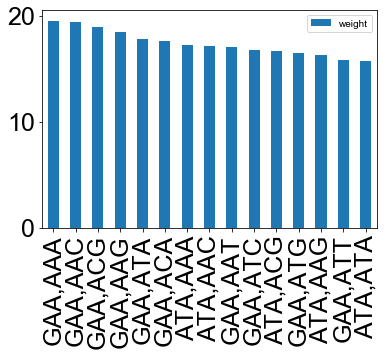

In [326]:
pd.DataFrame().from_dict(weights, orient='index', columns=['weight']) \
    .nlargest(15, 'weight')\
    .plot.bar()

In [327]:
df = pd.read_feather('/stor/work/Lambowitz/cdw2854/miRNA/new_NTT/MiR/mir_count.feather')
df.head()

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/pandas/io/feather_format.py:124: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  nthreads=int_use_threads)
/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/pyarrow/pandas_compat.py:751: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


,mir,MTT1_corrected,MTT1_filter,MTT2_corrected,MTT2_filter,MTT3_corrected,MTT3_filter,NTC1_corrected,NTC1_filter,NTC2_corrected,...,NTT3_corrected,NTT3_filter,NTT6N_corrected,NTT6N_filter,NTTR1_corrected,NTTR1_filter,NTTR2_corrected,NTTR2_filter,NTTR3_corrected,NTTR3_filter
0,EBV-1-1,480.484999,155.0,504.320955,281.0,550.909158,296.0,288.231209,140.0,169.532884,...,267.576013,137.0,257.078809,121.0,1424.424699,545.0,1025.424174,489.0,2520.514763,1122.0
1,EBV-1-2,5334.375850,7488.0,6384.205324,9065.0,7037.846078,9780.0,7502.694319,10546.0,7164.884498,...,10174.543667,14587.0,6285.707165,9487.0,5714.730298,7017.0,4374.065288,6110.0,5089.448822,7317.0
2,EBV-1-2-star,662.832977,517.0,1086.531618,678.0,1544.005770,975.0,228.112987,193.0,305.554771,...,1148.545614,848.0,1005.908357,857.0,861.746060,597.0,873.866329,695.0,1257.581071,921.0
3,EBV-1-3,567.676085,673.0,903.191084,1151.0,933.446113,1196.0,948.840044,1300.0,1148.402576,...,1012.729205,1508.0,669.125661,1026.0,273.707183,372.0,421.084173,579.0,541.804602,619.0
4,EBV-1-3P,2509.490276,2017.0,3203.850147,2365.0,3762.145746,3062.0,1709.309959,1244.0,1199.688312,...,1966.627432,1489.0,2421.193477,2081.0,11638.899681,9422.0,8651.353811,7210.0,6874.072045,5076.0


In [328]:
ce = color_encoder()
mir_df = df\
    .set_index('mir')\
    .transform(lambda x: x/x.sum() * 1e6)\
    .reset_index()\
    .fillna(0)\
    .pipe(pd.melt, id_vars='mir', value_name = 'mir_count', var_name = 'sn')\
    .assign(correct = lambda d: np.where(d['sn'].str.contains('corrected'), 'Corrected', 'Uncorrected'))\
    .assign(color = lambda d: ce.fit_transform(d.correct)) 
mir_df.head()

,mir,sn,mir_count,correct,color
0,EBV-1-1,MTT1_corrected,94.807589,Corrected,#56B4E9
1,EBV-1-2,MTT1_corrected,1052.560047,Corrected,#56B4E9
2,EBV-1-2-star,MTT1_corrected,130.787843,Corrected,#56B4E9
3,EBV-1-3,MTT1_corrected,112.011824,Corrected,#56B4E9
4,EBV-1-3P,MTT1_corrected,495.163685,Corrected,#56B4E9


In [329]:
rmse = mir_df \
    .groupby(['sn','correct','color'], as_index=False)\
    .agg({'mir_count': lambda x: mean_squared_error(np.log([1e6/962+1]*len(x)), 
                                                    np.log(x+1)) })\
    .assign(sn = lambda d: d.sn.str.extract('([A-Z]+[0-9]+)_'))\
    .pipe(pd.pivot_table, index=['sn'], columns = 'correct', values='mir_count') \
    .assign(Initial = lambda d: d.Uncorrected - d.Corrected) \
    .drop('Uncorrected', axis=1) \
    .filter(['Corrected', 'Initial'])\
    .rename(columns = {'Corrected':'Reweighed reads','Initial':'Intial reads'})

rmse

correct,Reweighed reads,Intial reads
sn,,
MTT1,2.729550,1.734261
MTT2,2.522000,1.726117
MTT3,2.410991,1.737486
NTC1,3.099208,1.807687
NTC2,4.346151,0.675699
NTC3,4.115167,0.615749
NTT1,3.449133,1.966327
NTT2,3.337409,1.975042
NTT3,3.256465,2.140510


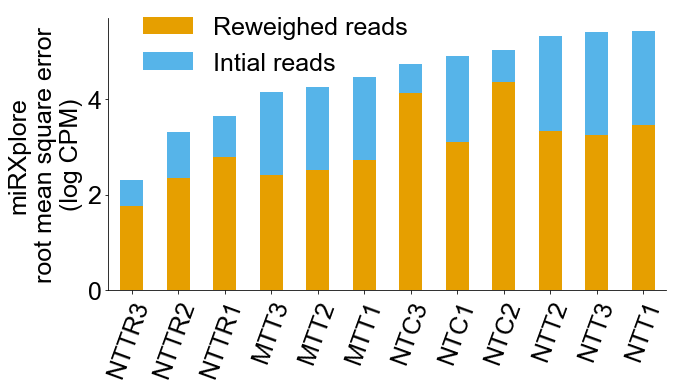

In [330]:
fig = plt.figure(figsize=(10,5))
ax = plt.subplot()
rmse\
    .assign(total = lambda d: d.sum(axis=1))\
    .sort_values('total')\
    .drop('total', axis=1)\
    .plot.bar(stacked=True, ax = ax, color = okabeito_palette() )
sns.despine()
ax.legend(fontsize=25, frameon=False, loc='center', bbox_to_anchor=(0.3,0.9))
xts = []
for xt in ax.get_xticklabels():
    xts.append(xt.get_text().split('_')[0])
ax.set_xticklabels(xts, rotation=70, rotation_mode = 'anchor', ha='right')
ax.set_xlabel('')
ax.set_ylabel('miRXplore\nroot mean square error\n(log CPM)')
fig.savefig('../figures/reweighted_rmse.pdf', bbox_inches='tight')

In [361]:
nuc_df = pd.read_feather('/stor/work/Lambowitz/cdw2854/miRNA/new_NTT/MiR/nuc_count.feather') \
    .set_index('pos')\
    .pipe(lambda d: d[d.samplename.str.contains('^NTT[0-9]+')])\
    .assign(corrected = lambda d: np.where(d.samplename.str.contains('corrected'),
                                   'corrected',
                                   'uncorrected'))\
    .assign(samplename = lambda d: d.samplename.str.extract('^([A-Z]+[0-9]+)_'))\
    .pipe(dd.from_pandas, npartitions=24)\
    .groupby(['pos','end','corrected'])\
    .apply(lambda d: d\
               .assign(base_fraction = lambda d: d.base_count/d.base_count.sum())\
               .filter(regex='base'),
          meta = {'base':'f8', 'base_count':'f8', 'base_fraction':'f8'}) \
    .compute()
nuc_df.index = nuc_df.index.droplevel(-1)
nuc_df = nuc_df\
    .reset_index()
nuc_df.head()

,pos,end,corrected,base,base_count,base_fraction
0,0,read1,corrected,G,1993.378300,0.016262
1,0,read1,corrected,A,3417.991650,0.027884
2,0,read1,corrected,C,5642.053905,0.046027
3,0,read1,corrected,T,21525.086700,0.175599
4,0,read1,corrected,G,1808.769211,0.014756


In [362]:
expected_nuc().head()

,base,expected_base_count,end,pos,expected_base_fraction
0,T,402,read1,0,0.417879
1,A,284,read1,0,0.295218
2,G,122,read1,0,0.126819
3,C,154,read1,0,0.160083
0,A,356,read1,1,0.370062


In [363]:
corrected_df =  nuc_df\
    .groupby(['corrected','end','pos','base'], as_index=False)\
    .agg({'base_fraction':'sum'}) \
    .sort_values('pos')\
    .reset_index(drop=True)\
    .merge(expected_nuc(), on =['pos','base','end'], how='left' )\
    .assign(end = lambda d: d.end.str.capitalize())\
    .assign(corrected = lambda d: d.corrected.str.capitalize())\
    .assign(pos = lambda d: d.pos + 1)\
    .assign(normalized = lambda d: d.base_fraction / d.expected_base_fraction)\
    .assign(corrected = lambda d: d.corrected.map({'Corrected':'Reweighed reads','Uncorrected':'Initial reads'}))\
    .assign(base = lambda d: d.base.str.replace('T','U')) \
    .query('pos < 7') \
    .assign(pos = lambda d: np.where(d.end=="Read2", 7-d.pos,d.pos))
corrected_df.head()

,corrected,end,pos,base,base_fraction,expected_base_count,expected_base_fraction,normalized
0,Reweighed reads,Read1,1,A,0.100390,284.0,0.295218,0.340053
1,Initial reads,Read2,6,U,0.193455,220.0,0.228690,0.845926
2,Initial reads,Read2,6,G,0.203665,179.0,0.186071,1.094557
3,Initial reads,Read2,6,C,0.550845,205.0,0.213098,2.584941
4,Initial reads,Read2,6,A,0.052035,358.0,0.372141,0.139826


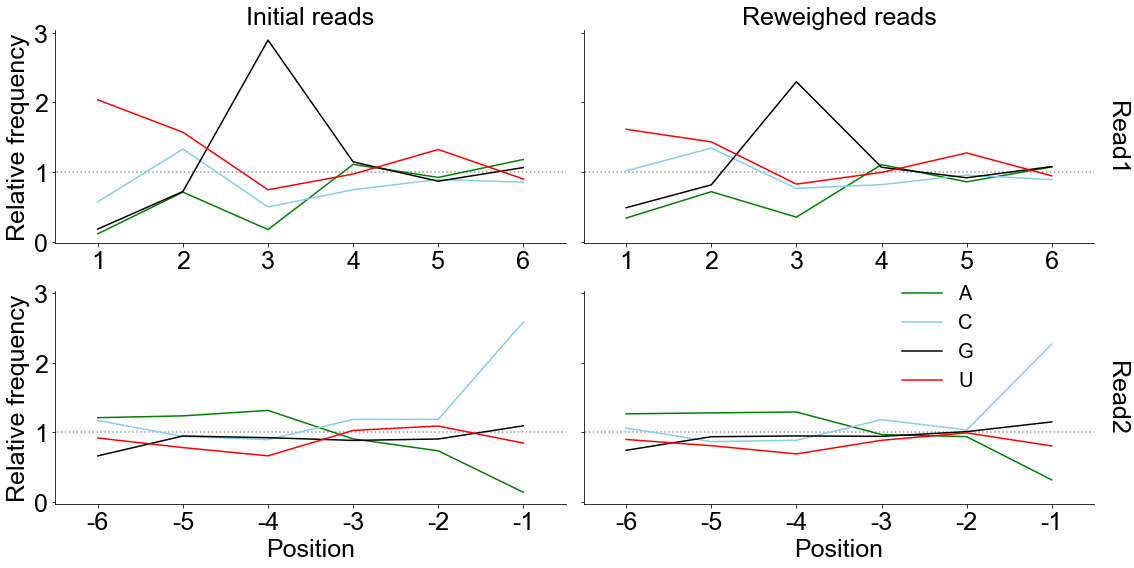

In [364]:
p = sns.FacetGrid(data=corrected_df, col='corrected', hue = 'base',
             palette = ['green','skyblue','black', 'red'],
             row_order = ['Read1','Read2'],
             col_order = ['Initial reads', 'Reweighed reads'],
             hue_order = ['A','C','G','U'],
             row= 'end',aspect=2, height=4,
             sharex=False,
             margin_titles=True)
p.map(plt.plot, 'pos', 'normalized')
for i, ax in enumerate(p.fig.axes):
    ax.hlines(xmin=0, xmax=16, y=1,linestyle=':', color='grey', alpha=0.8)
    if i > 1:
        ax.set_xticklabels(range(-7,0))
[plt.setp(ax.texts, text="") for ax in p.axes.flat] # remove the original texts
                                                    # important to add this before setting titles
p.set_titles(row_template = '{row_name}', col_template = '{col_name}', size=25)
p.add_legend(fontsize=20,title='', bbox_to_anchor=(0.8,0.4))
p.set_axis_labels('Position', 'Relative frequency')
p.set(xlim=(.5,6.5))
p.savefig('../figures/reweighted_nucleotide.eps', bbox_inches='tight')

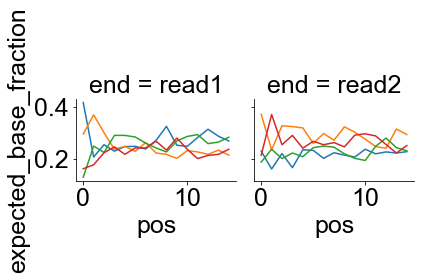

In [335]:
p = sns.FacetGrid(data = expected_nuc(),
             hue = 'base', col = 'end')
p.map(plt.plot, 'pos','expected_base_fraction')